In [1]:
import xarray as xr
import numpy as np
import os
import arrow
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

# fcHour_list = list(range(0, 72+1, 1)) + list(range(78, 168+1, 6))
fcHour_list = list(range(0, 72+1, 1)) + list(range(78, 120+1, 6))
dir_path =  os.path.normpath(os.path.join(root_dir, './data/netcdf/CFdata/fullhour/hdf'))

In [3]:
dirPath = dir_path.replace('\\','/')
reg =f"{dirPath}/*.hdf"
path_list = glob.glob(reg)
df_list = []
for i_path in path_list:
  print(f'读取{i_path}')
  try:
    store_hdf = pd.HDFStore(i_path, mode='r')
  except:
    print(f'读取HDF文件异常{i_path}')
    continue
  for iHour in fcHour_list:
    try:
      i_df = store_hdf.get(f'df_{iHour:0>3d}')
      df_list.append(i_df)
    except:
      continue

读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.0_20.0_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.0_20.25_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.25_20.0_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.25_20.25_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.5_20.0_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.0_pre110.5_20.25_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.125_pre110.0_20.0_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.125_pre110.0_20.25_allstation.hdf
读取F:/github/pythonScript/seafog/data/netcdf/CFdata/fullhour/hdf\full.suf110.0_20.125_pre110.25

In [4]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.sort_values(by=['init_time','fc_hour'], inplace=True, ignore_index=True)
df_all['station_vis_linear'] = -1.0
df_all['station_vis_linear'] = df_all['station_vis'].apply(linear_vis)
df_fog = df_all.loc[df_all['station_vis_cat'] == 0]
df_mist =  df_all.loc[df_all['station_vis_cat'] == 1]
df_clear =  df_all.loc[df_all['station_vis_cat'] == 2]
print(f'df_fog:{len(df_fog)}  df_mist:{len(df_mist)}  df_clear:{len(df_clear)}')

df_fog:261384  df_mist:6040210  df_clear:9671677


In [ ]:

plt.plot(df_all['station_vis_linear'],df_all['station_vis_linear'],'.')
plt.show()

In [5]:
df_all.keys()

Index(['sstk', 't2md', 't2mm', 'u100', 'u10m', 'v100', 'v10m', 'visi',
       'rhum1000', 'rhum950', 'rhum925', 'rhum900', 'rhum850', 'temp1000',
       'temp950', 'temp925', 'temp900', 'temp850', 'theta_e1000', 'theta1000',
       'theta_e950', 'theta950', 'theta_e925', 'theta925', 'theta_e900',
       'theta900', 'theta_e850', 'theta850', 'actual_time', 'init_time',
       'year', 'month', 'day', 'hour', 'year_sin', 'year_cos', 'day_sin',
       'day_cos', 'station_vis', 'station_rain1', 'fc_hour', 'station_vis_cat',
       'station_vis_linear'],
      dtype='object')

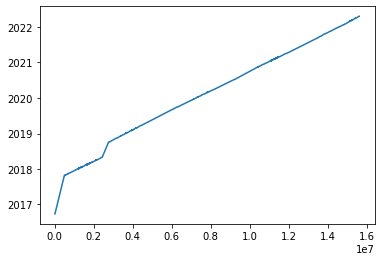

Timestamp('2016-09-01 00:00:00')

In [8]:
plt.plot(df_fog['actual_time'])
plt.show()
np.min(df_all['actual_time'])

In [9]:
print(len(df_fog))
print(len(df_mist))
print(len(df_clear))

261384
6040210
9671677


In [13]:
partial_train = 7.0/11.0
partial_valid = 2.0/11.0
partial_test = 2.0/11.0
df_fog_train = df_fog[:int(len(df_fog)*partial_train)] # 训练集
df_fog_valid = df_fog[int(len(df_fog)*partial_train):int(len(df_fog)*partial_train)+int(len(df_fog)*partial_valid)] # 验证集
df_fog_test  = df_fog[int(len(df_fog)*partial_train)+int(len(df_fog)*partial_valid):] # 测试集
# 检查fog的日期
fog_valid_sTime = df_fog_valid['actual_time'].iat[0]
fog_test_sTime = df_fog_test['actual_time'].iat[0]

df_mist_train = df_mist.loc[df_mist['actual_time'].values<fog_valid_sTime]
df_mist_valid = df_mist.loc[(df_mist['actual_time'].values>=fog_valid_sTime) & (df_mist['actual_time'].values<fog_test_sTime)]
df_mist_test = df_mist.loc[df_mist['actual_time'].values>=fog_test_sTime]

df_clear_train = df_clear.loc[df_clear['actual_time'].values<fog_valid_sTime]
# df_clear_valid = df_clear.loc[(df_clear['actual_time'].values>=fog_valid_sTime) & (df_clear['actual_time'].values<fog_test_sTime)]
df_clear_valid = df_clear.loc[df_clear['actual_time'].values>=fog_valid_sTime]
df_clear_test = df_clear.loc[df_clear['actual_time'].values>=fog_test_sTime]
print(f'df_fog_train:{len(df_fog_train)}  df_fog_valid:{len(df_fog_valid)}  df_fog_test:{len(df_fog_test)}')

df_fog_train:166335  df_fog_valid:47524  df_fog_test:47525


In [14]:
len(df_clear_valid)

2991846

In [ ]:
fool = df_clear.loc[(df_clear['actual_time'].values>=fog_valid_sTime)]['actual_time']
print(fool.iloc[0:10])

In [ ]:
print(fog_valid_sTime)
print(fog_test_sTime)

In [ ]:
print(len(df_fog_train))
print(len(df_fog_valid))
print(len(df_fog_test))

In [15]:
# 增加雾的数量
# df_fog_train_extend = pd.concat([df_fog_train]*1, ignore_index=True)
# df_fog_valid_extend = pd.concat([df_fog_valid]*1, ignore_index=True)
df_fog_train_extend = df_fog_train
df_fog_valid_extend = df_fog_valid
# fog顺序排列, mist和clear数量保持一致
df_mist_train = df_mist_train.sample(n=len(df_fog_train_extend), replace=True)
df_clear_train = df_clear_train.sample(n=len(df_fog_train_extend), replace=True)

df_mist_valid = df_mist_valid.sample(n=len(df_fog_valid), replace=True)
df_clear_valid = df_clear_valid.sample(n=len(df_fog_valid), replace=True)

df_mist_test = df_mist_valid.sample(n=len(df_fog_test), replace=True)
df_clear_test = df_clear_valid.sample(n=len(df_fog_test), replace=True)
# df_clear_sample = df_clear.sample(n=20000)
# df_mist_sample = df_mist.sample(n=20000)
print(len(df_mist_train))
print(len(df_clear_train))
print(len(df_fog_train_extend))


166335
166335
166335


In [16]:
df_train = pd.concat([df_fog_train_extend, df_mist_train, df_clear_train], ignore_index=True)
df_valid = pd.concat([df_fog_valid_extend, df_mist_valid, df_clear_valid], ignore_index=True)
df_test = pd.concat([df_fog_test, df_mist_test, df_clear_test], ignore_index=True)

In [17]:
df_train = df_train.sample(frac=1)
# df_valid = df_valid.sample(frac=1)
# df_test = df_test.sample(frac=1)


In [ ]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))

In [18]:
real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test[df_test['fc_hour'].isin(real_fcHour_list) ]
print(len(df_test_real))

59059


In [19]:
df_test_real = df_test
df_valid_test = pd.concat([df_valid, df_test_real], ignore_index=True)

In [20]:
fog_dataset_hdf = os.path.normpath(os.path.join(dir_path, './fog_dataset_hdf66.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='w')
df_train.to_hdf(store_dataset, key=f'train', mode='a')
df_valid.to_hdf(store_dataset, key=f'valid', mode='a')
df_test_real.to_hdf( store_dataset, key=f'test' , mode='a')
df_valid_test.to_hdf( store_dataset, key=f'valid_test' , mode='a')
store_dataset.close()


In [ ]:
# 提取需要的变量组成x, 提取vis_cat作为y